# Modeling - CNN

In [1]:
# Import libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
  # %tensorflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras
sns.set(context='talk')

TensorFlow 2.x selected.


## Data preprocessing

In [2]:
# Mount Google Drive where data is located
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Unzip data
!unzip '/content/drive/My Drive/data.zip'

Archive:  /content/drive/My Drive/data.zip
   creating: data/
   creating: data/train/
   creating: data/train/bak_chor_mee/
  inflating: data/train/bak_chor_mee/0000f56e768f0210598c26d059cc9b56eb72d3d2.jpg  
  inflating: data/train/bak_chor_mee/002b67377afbd1d13a99164cda2de8abbb7824cb.jpg  
  inflating: data/train/bak_chor_mee/004ea44897fb1035d148ac8964e629ad4a6d172e.jpg  
  inflating: data/train/bak_chor_mee/007b766a6e28835fbd9ab57a6ee5230bd70e8d29.jpg  
  inflating: data/train/bak_chor_mee/00a9c72be1b309c4c39891717d5e92bf0202f442.jpg  
  inflating: data/train/bak_chor_mee/00c3b42696ad8d70c2ac47795f271b8a9e169d3c.jpg  
  inflating: data/train/bak_chor_mee/00cae12ec6e92d55cf2fc637fd6de6fee1b14c46.jpg  
  inflating: data/train/bak_chor_mee/00dfa7802daa6b266f5eb3934ea319e4c69bac69.jpg  
  inflating: data/train/bak_chor_mee/00e8c7415156efde87ecc5fee5b6253aa11f02bc.jpg  
  inflating: data/train/bak_chor_mee/015f45763282b9bbe017c5253e5815e27a15c152.jpg  
  inflating: data/train/bak_chor_me

In [0]:
# Format images for classification: all images will be resized to 224x224
img_width, img_height = 224, 224 
train_data_dir = './data/train'
validation_data_dir = './data/validation'
batch_size = 32
num_train = 13200
num_validation = 3300

In [5]:
# Data augmentation configuration for train data
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

# Data augmentation configuration for test data: only rescaling
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255)

# Generator that reads pictures found in subfolers of 'data/train'
# and indefinitely generate batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Similar generator for validation data
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# Map index to class names
classes = dict((v, k.replace('_', ' ').title()) for k, v in train_generator.class_indices.items())

Found 13200 images belonging to 11 classes.
Found 3300 images belonging to 11 classes.


## Create base model from pre-trained network

## Feature extraction

In [0]:
# Define model structure
model = keras.Sequential([keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(img_width, img_height, 3)),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Dropout(0.2),
                          keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Dropout(0.2),
                          keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
                          keras.layers.MaxPooling2D(),
                          keras.layers.Dropout(0.2),
                          keras.layers.Flatten(),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dropout(0.2),
                          keras.layers.Dense(11, activation='softmax')])

In [0]:
# Compile model
top3_acc = keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy')
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy', top3_acc])

In [8]:
# Examine model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

In [9]:
initial_epochs = 100

callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False)

# Train model with early stopping
history = model.fit_generator(
    train_generator,
    epochs=initial_epochs,
    steps_per_epoch=num_train // batch_size,
    validation_data=validation_generator,
    validation_steps=num_validation // batch_size,
    callbacks=[callback])

Epoch 1/100
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
412/412 [==============================] - 285s 692ms/step - loss: 2.2044 - accuracy: 0.2077 - top_3_categorical_accuracy: 0.4643 - val_loss: 1.9593 - val_accuracy: 0.3817 - val_top_3_categorical_accuracy: 0.6696
Epoch 2/100
412/412 [==============================] - 281s 683ms/step - loss: 1.8727 - accuracy: 0.3526 - top_3_categorical_accuracy: 0.6482 - val_loss: 1.8552 - val_accuracy: 0.3771 - val_top_3_categorical_accuracy: 0.6626
Epoch 3/100
412/412 [==============================] - 279s 678ms/step - loss: 1.7272 - accuracy: 0.4023 - top_3_categorical_accuracy: 0.6996 - val_loss: 1.7227 - val_accuracy: 0.4299 - val_top_3_categorical_accuracy: 0.7248
Epoch 4/100
412/412 [==============================] - 279s 677ms/step - loss: 1.5949 - accuracy: 0.4534 - top_3_categorical_accuracy: 0.7464 - val_loss: 1.6581 - val_accuracy: 0.4533 - val_top_3_categorical_accuracy: 0.7527
Epoch 

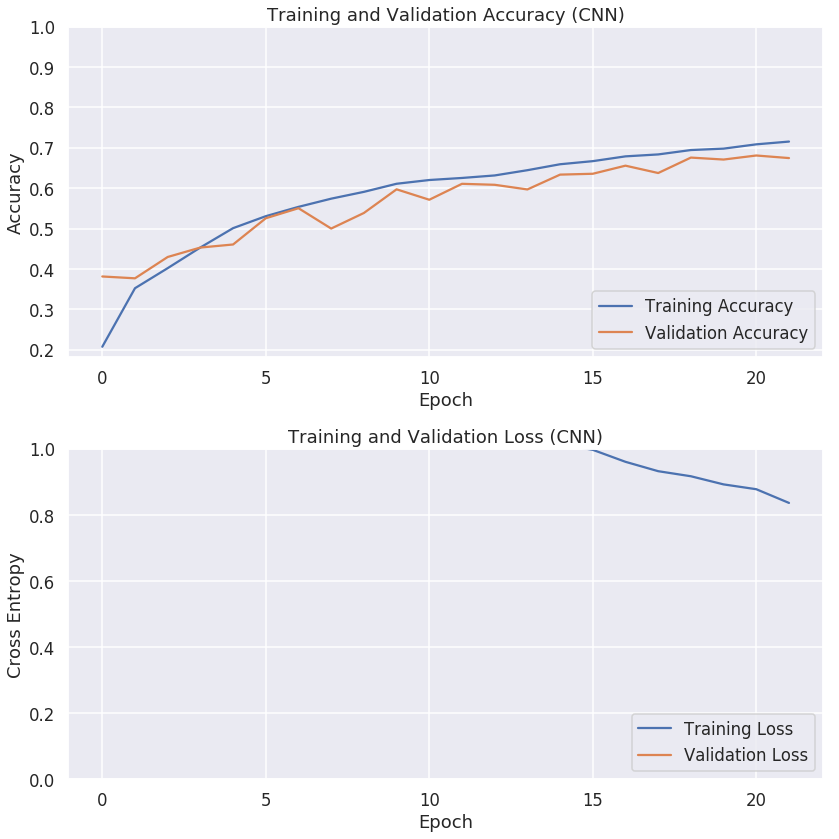

In [10]:
# Plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss (CNN)')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

In [0]:
# Save TensorFlow model
model.save('/content/drive/My Drive/model_cnn.h5')

## Prediction and evaluation

In [0]:
# Load trained model
model = keras.models.load_model('/content/drive/My Drive/model_cnn.h5')

Text(10, 10, 'Roti Prata\n0.6279141')

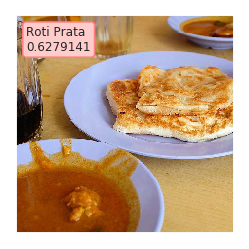

In [13]:
# Load random image from validation set
x_batch = next(validation_generator)
example_img = x_batch[0][0]

# Make prediction
input_vector = np.expand_dims(example_img,0).astype(np.float32)
img_predict = model.predict(input_vector)[0]
img_class = classes[np.argmax(img_predict)]
img_proba = max(img_predict)

# Plot image with predicted class
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(example_img)
plt.text(10, 10, '{}\n{}'.format(img_class, str(img_proba)), size=12,
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1., 0.8, 0.8)))

In [14]:
# Add additional parameters to validation data generator  
# to ensure reproducibility during metrics evaluation
class_validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42)

Found 3300 images belonging to 11 classes.


In [15]:
from tqdm import tqdm_notebook as tqdm

# Obtain predicted and true values from validation data
y_pred = []
y_true = []
class_validation_generator.reset()
for batch in tqdm(range(len(class_validation_generator))):
  y_pred.append(np.argmax(model.predict(np.expand_dims(class_validation_generator[batch][0][0], 0))))
  y_true.append(np.argmax(class_validation_generator[batch][1][0]))

In [16]:
# Generate report showing classification metrics:
# precision, recall and f1 score
from sklearn.metrics import classification_report
report_dict = classification_report(y_true, y_pred, target_names=list(classes.values()), output_dict=True)
print(classification_report(y_true, y_pred, target_names=list(classes.values())))

                   precision    recall  f1-score   support

     Bak Chor Mee       0.47      0.61      0.53       300
      Bak Kut Teh       0.83      0.64      0.72       300
   Char Kway Teow       0.57      0.90      0.70       300
     Chicken Rice       0.87      0.60      0.71       300
Fried Hokkien Mee       0.69      0.56      0.62       300
            Laksa       0.83      0.64      0.72       300
       Nasi Lemak       0.61      0.78      0.68       300
         Non Food       0.81      0.87      0.84       300
       Roti Prata       0.82      0.62      0.71       300
            Satay       0.55      0.69      0.61       300
       Wanton Mee       0.75      0.52      0.61       300

         accuracy                           0.68      3300
        macro avg       0.71      0.68      0.68      3300
     weighted avg       0.71      0.68      0.68      3300



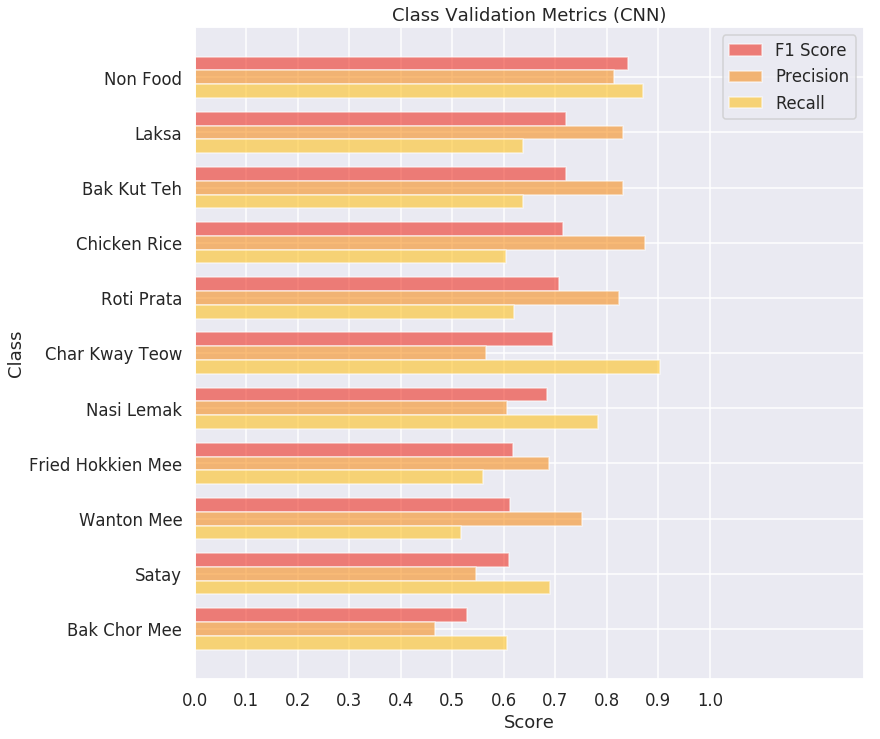

In [17]:
# Plot class validation metrics

df_plot = pd.DataFrame(report_dict).T.drop(index=['accuracy','macro avg', 'weighted avg']).sort_values(by='f1-score')

pos = np.arange(len(df_plot['f1-score']))
height = 0.25
fig, ax = plt.subplots(figsize=(12,12))

plt.barh(pos,
         width=df_plot['f1-score'],
         height=height,
         alpha=0.6,
         color='#EE3224')

plt.barh([p - height for p in pos],
         width=df_plot['precision'],
         height=height,
         alpha=0.6,
         color='#F78F1E')

plt.barh([p - height*2 for p in pos],
         width=df_plot['recall'],
         height=height,
         alpha=0.6,
         color='#FFC222')

ax.set_title('Class Validation Metrics (CNN)')
ax.set_xlabel('Score')
ax.set_ylabel('Class')
ax.set_yticklabels(df_plot.index)
ax.set_yticks([p - 1 * height for p in pos])
ax.set_xlim([0, 1.3])
ax.set_xticks(np.arange(0, 1.01, step=0.1))
plt.legend(['F1 Score', 'Precision', 'Recall'], loc='upper right')
plt.show()